# Node Feature Creation

The following notebook outlines the features that will be created for the node attributes. At the end of the notebook, csv file will be written with 

In [1]:
from pyspark.sql.functions import explode, col, size,  array_except, current_date, datediff, expr, lit, max, element_at, array_max, length, desc, sum, broadcast
import pyspark.sql.functions as F
import warnings
import matplotlib.pyplot as plt
from functools import reduce


warnings.filterwarnings("ignore")

In [2]:
%run Social_Networking_Project/Data-Retrieval.ipynb

In [3]:
user = user.withColumn("friend_count", size(col("friends")))

In [4]:
#Add to this to remove more users and subset graph data
user = user.filter((col('friend_count') >= 128)).cache()

In [5]:
user.count()

250261

## Agregate compliments

In [6]:
last_11_column_names = user.columns[-11:]
sum_expression = reduce(lambda a, b: a + b, (col(c) for c in last_11_column_names))
user = user.withColumn("total_compliments", sum_expression)
user.limit(5).toPandas()

,user_id,name,review_count,yelping_since,friends,useful,funny,cool,fans,elite,...,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos,friend_count,total_compliments
0,qVc8ODYU5SZjKXVBgXdI7w,Walker,585,2007-01-25 16:47:26,"[NSCy54eWehBJyZdG2iE84w, pe42u7DcCH2QmI81NX-8q...",7217,1259,5994,267,[2007],...,56,18,232,844,467,467,239,180,14995,17618
1,j14WgRoU_-2ZE1aw1dXrJg,Daniel,4333,2009-01-25 04:35:42,"[ueRPE0CX75ePGMqOFVj6IQ, 52oH4DrRvzzl8wh5UXyU0...",43091,13066,27281,3138,"[2009, 2010, 2011, 2012, 2013, 2014, 2015, 201...",...,157,251,1847,7054,3131,3131,1521,1946,4646,24132
2,2WnXYQFK0hXEoTxPtV2zvg,Steph,665,2008-07-25 10:41:00,"[LuO3Bn4f3rlhyHIaNfTlnA, j9B4XdHUhDfTKVecyWQgy...",2086,1010,1003,52,"[2009, 2010, 2011, 2012, 2013]",...,17,3,66,96,119,119,35,18,381,877
3,SZDeASXq7o05mMNLshsdIA,Gwen,224,2005-11-29 04:38:33,"[enx1vVPnfdNUdPho6PH_wg, 4wOcvMLtU6a9Lslggq74V...",512,330,299,28,"[2009, 2010, 2011]",...,6,2,12,16,26,26,10,9,131,243
4,q_QQ5kBBwlCcbL1s4NVK3g,Jane,1221,2005-03-14 20:26:35,"[xBDpTUbai0DXrvxCe3X16Q, 7GPNBO496aecrjJfW6UWt...",14953,9940,11211,1357,"[2006, 2007, 2008, 2009, 2010, 2011, 2012, 201...",...,361,147,1212,5696,2543,2543,815,323,5843,19837


In [7]:
user = user.drop(*last_11_column_names)

In [8]:
pandas_df = user.select("total_compliments").toPandas()

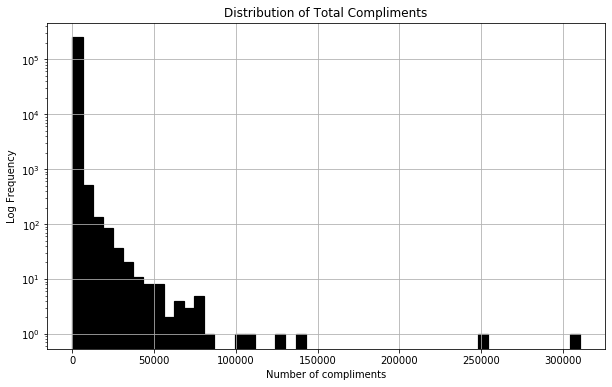

In [9]:
# Create distribution plot using matplotlib
plt.figure(figsize=(10, 6))
plt.hist(pandas_df["total_compliments"], bins=50, color='black', edgecolor='black', linewidth=1.2)
plt.title("Distribution of Total Compliments")
plt.xlabel("Number of compliments")
plt.ylabel("Log Frequency")
plt.yscale('log')
plt.grid(True)
plt.savefig("Social_Networking_Project/Images/total_compliments.png")
plt.show()

In [10]:
pandas_df["total_compliments"].describe()

count    250261.000000
mean        399.036830
std        1473.198917
min         128.000000
25%         174.000000
50%         243.000000
75%         377.000000
max      310203.000000
Name: total_compliments, dtype: float64

## Days Yelping

In [11]:
max_date = user.agg({ "yelping_since": "max" }).collect()[0][0]

In [12]:
user = user.withColumn("days_since_yelping", datediff(lit(max_date), "yelping_since"))

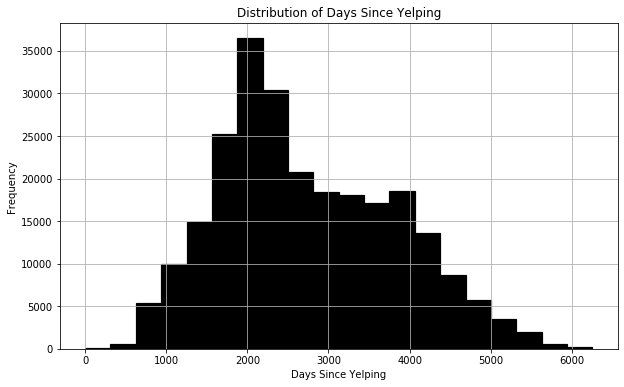

In [13]:
pandas_df = user.select("days_since_yelping").toPandas()

# Create distribution plot using matplotlib
plt.figure(figsize=(10, 6))
plt.hist(pandas_df["days_since_yelping"], bins=20, color='black', edgecolor='black', linewidth=1.2)
plt.title("Distribution of Days Since Yelping")
plt.xlabel("Days Since Yelping")
plt.ylabel("Frequency")
plt.grid(True)
plt.savefig("Social_Networking_Project/Images/days_yelping.png")
plt.show()

## Years elite

In [14]:
user = user.withColumn("years_elite",
                       when(col("elite").isNull() | (size(col("elite")) == 0) | (length(col("elite").getItem(0)) == 0), 0)
                       .otherwise(size("elite")))

In [15]:
user.limit(5).toPandas()

,user_id,name,review_count,yelping_since,friends,useful,funny,cool,fans,elite,average_stars,compliment_hot,total_compliments,days_since_yelping,years_elite
0,qVc8ODYU5SZjKXVBgXdI7w,Walker,585,2007-01-25 16:47:26,"[NSCy54eWehBJyZdG2iE84w, pe42u7DcCH2QmI81NX-8q...",7217,1259,5994,267,[2007],3.91,250,17618,5417,1
1,j14WgRoU_-2ZE1aw1dXrJg,Daniel,4333,2009-01-25 04:35:42,"[ueRPE0CX75ePGMqOFVj6IQ, 52oH4DrRvzzl8wh5UXyU0...",43091,13066,27281,3138,"[2009, 2010, 2011, 2012, 2013, 2014, 2015, 201...",3.74,1145,24132,4686,14
2,2WnXYQFK0hXEoTxPtV2zvg,Steph,665,2008-07-25 10:41:00,"[LuO3Bn4f3rlhyHIaNfTlnA, j9B4XdHUhDfTKVecyWQgy...",2086,1010,1003,52,"[2009, 2010, 2011, 2012, 2013]",3.32,89,877,4870,5
3,SZDeASXq7o05mMNLshsdIA,Gwen,224,2005-11-29 04:38:33,"[enx1vVPnfdNUdPho6PH_wg, 4wOcvMLtU6a9Lslggq74V...",512,330,299,28,"[2009, 2010, 2011]",4.27,24,243,5839,3
4,q_QQ5kBBwlCcbL1s4NVK3g,Jane,1221,2005-03-14 20:26:35,"[xBDpTUbai0DXrvxCe3X16Q, 7GPNBO496aecrjJfW6UWt...",14953,9940,11211,1357,"[2006, 2007, 2008, 2009, 2010, 2011, 2012, 201...",3.85,1713,19837,6099,9


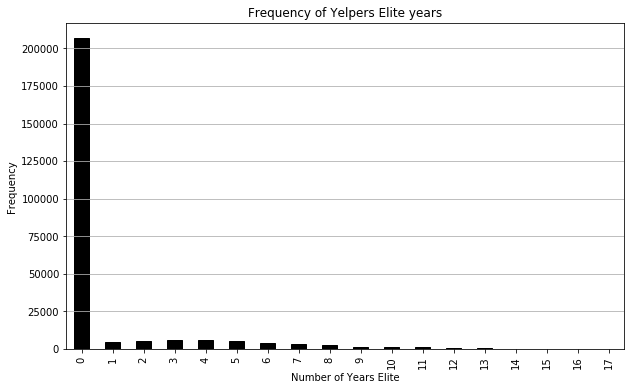

In [16]:
pandas_df = user.select("years_elite").toPandas()
frequency_counts = pandas_df["years_elite"].value_counts().sort_index()

# Plot frequency of non-zero values
plt.figure(figsize=(10, 6))
frequency_counts.plot(kind='bar', color='black', edgecolor='black')
plt.title("Frequency of Yelpers Elite years")
plt.xlabel("Number of Years Elite")
plt.ylabel("Frequency")
plt.grid(axis='y')
plt.show()

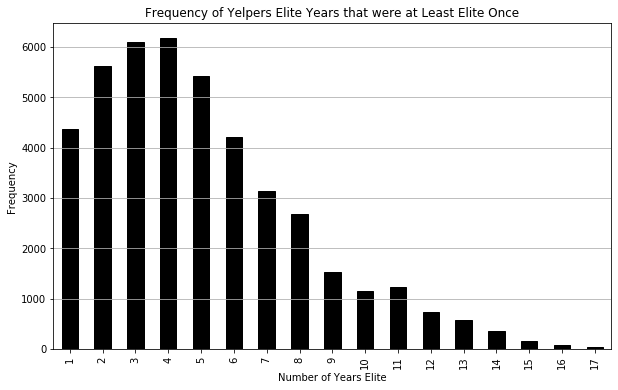

In [17]:
# Filter out rows where years_elite is not zero
pandas_df_filtered = pandas_df[pandas_df["years_elite"] != 0]
frequency_counts = pandas_df_filtered["years_elite"].value_counts().sort_index()

# Plot frequency of non-zero values
plt.figure(figsize=(10, 6))
frequency_counts.plot(kind='bar', color='black', edgecolor='black')
plt.title("Frequency of Yelpers Elite Years that were at Least Elite Once")
plt.xlabel("Number of Years Elite")
plt.ylabel("Frequency")
plt.grid(axis='y')
plt.savefig("Social_Networking_Project/Images/years_elite.png")
plt.show()

## Last Year Elite

In [18]:
user = user.withColumn("max_elite", array_max(col("elite"))) \
                          .withColumn("years_since_elite", expr("2021-max_elite"))
user = user.fillna(17, subset=['years_since_elite'])
user = user.withColumn("years_since_elite", when(col("years_since_elite") == 2001, 1).otherwise(col("years_since_elite")))

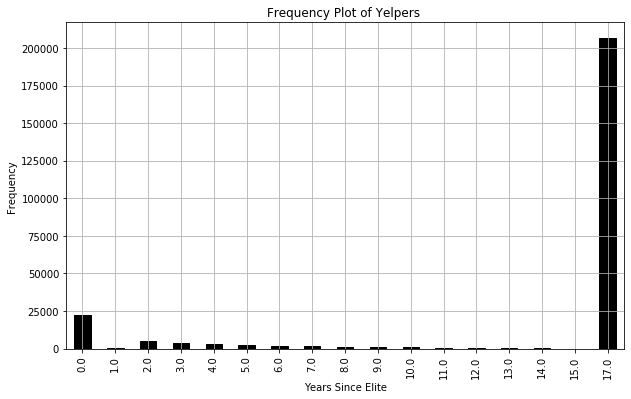

In [19]:
pandas_df = user.select("years_since_elite").toPandas()
frequency = pandas_df["years_since_elite"].value_counts()
frequency_counts = pandas_df["years_since_elite"].value_counts().sort_index()

plt.figure(figsize=(10, 6))
frequency_counts.plot(kind='bar', color='black', edgecolor='black')
plt.title("Frequency Plot of Yelpers ")
plt.xlabel("Years Since Elite")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

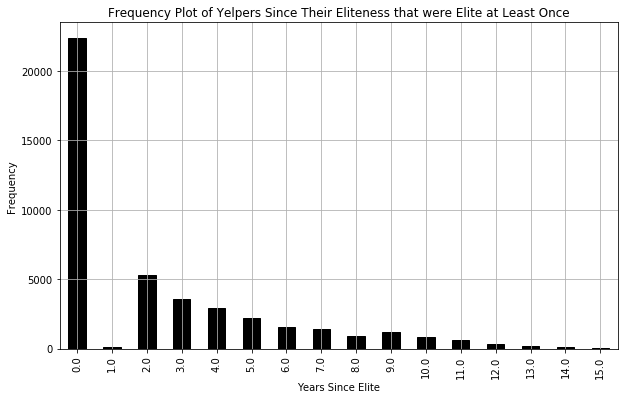

In [20]:
# Filter out rows where years_elite is not zero
pandas_df_filtered = pandas_df[pandas_df["years_since_elite"] != 17]
frequency_counts = pandas_df_filtered["years_since_elite"].value_counts().sort_index()

# Plot frequency of non-zero values
plt.figure(figsize=(10, 6))
frequency_counts.plot(kind='bar', color='black', edgecolor='black')
plt.title("Frequency Plot of Yelpers Since Their Eliteness that were Elite at Least Once")
plt.xlabel("Years Since Elite")
plt.ylabel("Frequency")
plt.grid(True)
plt.savefig("Social_Networking_Project/Images/years_since_last_elite.png")
plt.show()

## Business Category

In [21]:
business.select("categories").limit(5).toPandas()

,categories
0,"[Doctors, Traditional Chinese Medicine, Naturo..."
1,"[Shipping Centers, Local Services, Notaries, M..."
2,"[Department Stores, Shopping, Fashion, Home & ..."
3,"[Restaurants, Food, Bubble Tea, Coffee & Tea, ..."
4,"[Brewpubs, Breweries, Food]"


In [22]:
cats = business.select(explode("categories").alias("category"))
category_counts = cats.groupBy("category").count()

In [23]:
#1300 different categories
category_counts.orderBy(desc("count")).limit(50).show()

+--------------------+-----+
|            category|count|
+--------------------+-----+
|         Restaurants|52268|
|                Food|27781|
|            Shopping|24395|
|       Home Services|14356|
|       Beauty & Spas|14292|
|           Nightlife|12281|
|    Health & Medical|11890|
|      Local Services|11198|
|                Bars|11065|
|          Automotive|10773|
|Event Planning & ...| 9895|
|          Sandwiches| 8366|
|American (Traditi...| 8139|
|         Active Life| 7687|
|               Pizza| 7093|
|        Coffee & Tea| 6703|
|           Fast Food| 6472|
|  Breakfast & Brunch| 6239|
|      American (New)| 6097|
|     Hotels & Travel| 5857|
+--------------------+-----+
only showing top 20 rows



In [24]:
#Write file to get generalized categories from GPT
#category_counts.coalesce(1).write.csv(f"{proj_directory}categories.csv", header= True)

In [25]:
#These were the generalized catgories found in categories from GPT
general_categories = {
    "Health_Beauty_Rec": [
        "Acupuncture", "Alternative Medicine", "Chiropractors", "Dental Hygienists",
        "Dermatologists", "Dietitians", "Doctors", "Massage Therapy", "Medical Spas",
        "Mental Health", "Naturopathic/Holistic", "Nutritionists", "Optometrists",
        "Personal Care Services", "Physical Therapy", "Psychologists", "Reflexology",
        "Rehabilitation Center", "Sports Medicine", "Traditional Chinese Medicine",
        "Weight Loss Centers", "Health & Wellness", "General Dentistry","Barbers", 
        "Cosmetics & Beauty Supply", "Day Spas", "Eyebrow Services",
        "Eyelash Service", "Hair Extensions", "Hair Removal", "Hair Salons",
        "Makeup Artists", "Massage", "Nail Salons", "Perfume", "Skin Care", "Tanning Salons",
        "Tattoo", "Beauty & Personal Care", "Massage", "Waxing", "Baseball Fields", "Basketball Courts", "Bike Rentals", "Boating", "Bowling",
        "Climbing", "Diving", "Fishing", "Fitness & Instruction", "Golf",
        "Hiking", "Horse Racing", "Horseback Riding", "Hot Air Balloons", "Kiteboarding",
        "Lakes", "Parks", "Rafting/Kayaking", "Recreation Centers", "Ski Resorts",
        "Soccer", "Sports Clubs", "Surfing", "Swimming Pools", "Tennis", "Sports & Recreation",
        "Active Life", "Gyms"
    ],
    "Food_Dining": [
        "Bagels", "Bakeries", "Beer, Wine & Spirits", "Breweries", "Bubble Tea",
        "Butcher", "Cafes", "Coffee & Tea", "Convenience Stores", "Desserts",
        "Donuts", "Farmers Market", "Food Delivery Services", "Food Trucks",
        "Grocery", "Ice Cream & Frozen Yogurt", "Juice Bars & Smoothies",
        "Restaurants", "Seafood Markets", "Wineries", "Breakfast & Brunch", "Food", "Food & Dining",
        "Sandwiches", "American (Traditional)", "Pizza", "Fast Food", "Italian", "Mexican","Salad",
        "American (New)", "Burgers", "Speciality Food", "Seafood", "Chinese", "Chicken Wings", "Delis",
        "Sports Bar", "Japenese", "Barbeque", "Sushi Bars", "Soup", "Tacos", "Southern", "Thai",
        "Tex-Mex", "Cajun/Creole"
    ],
    "Shopping_Retail": [
        "Antiques", "Art Supplies", "Bookstores", "Bridal", "Clothing Stores",
        "Computers", "Consumer Electronics", "Department Stores", "Eyewear & Opticians",
        "Fashion", "Flea Markets", "Florists", "Furniture Stores", "Gift Shops",
        "Hardware Stores", "Home & Garden", "Jewelry", "Luggage", "Musical Instruments & Teachers",
        "Office Equipment", "Outlet Stores", "Pawn Shops", "Shopping Centers", "Sporting Goods",
        "Thrift Stores", "Toy Stores", "Watches", "Wholesale Stores", "Shopping", "Shopping & Retail",
        "Women's Clothing", "Flowers & Gifts"
    ],
    "Home_Services": [
        "Building Supplies", "Carpenters", "Carpet Installation", "Carpeting",
        "Contractors", "Electricians", "Flooring", "Garage Door Services",
        "Gardeners", "Handyman", "Heating & Air Conditioning/HVAC", "Home Cleaning",
        "Home Inspectors", "Interior Design", "Landscaping", "Locksmiths", "Movers",
        "Painters", "Plumbing", "Real Estate", "Roofing", "Security Systems",
        "Solar Installation", "Television Service Providers", "Window Washing", "Windows Installation", 
        "Home Services", "Home & Garden", "Apartments", "Commercial Real Estate", "Home Staging", "Mortgage Brokers",
        "Property Management", "Real Estate Agents", "Real Estate Services", "Shared Office Spaces",
        "Real Estate Developers", "Real Estate", "Building Supplies", "Contractors", "Electricians", "Flooring", "General Contractors",
        "HVAC", "Landscaping", "Masonry/Concrete", "Painters", "Plumbing", "Roofing", "Carpenters",
        "Windows Installation", "Construction & Contractors"
    ],
    "Professional_Services": [
        "Accountants", "Advertising", "Architects", "Career Counseling", "Employment Agencies",
        "Graphic Design", "Internet Service Providers", "IT Services & Computer Repair", "Lawyers",
        "Marketing", "Office Cleaning", "Printing Services", "Public Relations", "Security Services",
        "Web Design", "Professional Services", "Banks", "Credit Unions", "Financial Advising", "Insurance", "Investing",
        "Mortgage Lenders", "Tax Services", "Debt Relief Services", "Currency Exchange",
        "Payment Processing", "Financial Services",        "Computer Repair", "Data Recovery", "Electronics Repair", "Home Automation",
        "Internet Service Providers", "Mobile Phones", "Security Systems", "Software Development",
        "Web Design", "IT Services & Computer Repair", "Technology & Electronics"
    ],
    "Arts_Entertainment_Party": [
        "Amusement Parks", "Art Galleries", "Bingo Halls", "Botanical Gardens", "Cinema",
        "Cultural Center", "Festivals", "Jazz & Blues", "Museums", "Music Venues",
        "Opera & Ballet", "Performing Arts", "Race Tracks", "Social Clubs", "Stadiums & Arenas",
        "Ticket Sales", "Zoos", "Arts & Entertainment", "Nightlife", "Bars","Pubs", "Cocktail Bars",
        "Caterers", "DJ Services", "Event Planning", "Party & Event Planning", "Wedding Planning",
        "Party Supplies", "Personal Chefs", "Photographers", "Venues & Event Spaces", "Videographers",
        "Event Planning & Services"
    ],
    "Public_Transportation_Education": [
        "Community Service/Non-Profit", "Courthouses", "Fire Departments", "Landmarks & Historical Buildings",
        "Libraries", "Municipalities", "Police Departments", "Post Offices", "Social Clubs", "Historical Tours",
        "Public & Social Services", "Airlines", "Airports", "Bus Stations", "Couriers & Delivery Services", "Freight Forwarding",
        "Public Transportation", "Taxis", "Transportation", "Trucking", "Moving Companies",
        "Vehicle Shipping", "Warehousing & Storage", "Transportation & Logistics", "Airports", "Bed & Breakfast", "Car Rental", "Guest Houses", "Hostels",
        "Hotels", "Resorts", "Tour Operators", "Travel Services", "Vacation Rentals",
        "Travel & Accommodation", "Hotels & Travel","Auto Detailing", "Auto Glass Services", "Auto Loan Providers", "Auto Parts & Supplies",
        "Auto Repair", "Car Dealers", "Car Wash", "Gas Stations", "Motorcycle Repair",
        "Oil Change Stations", "Parking", "Tires", "Towing", "Vehicle Wraps", "Automotive Services",
        "Auto Repair", "Adult Education", "Art Classes", "Colleges & Universities", "Cooking Schools",
        "Dance Schools", "Driving Schools", "Educational Services", "Language Schools",
        "Music Lessons", "Preschools", "Private Tutors", "Test Preparation", "Tutoring Centers",
        "Vocational & Technical School", "Education & Learning", "Education", "Books", "Mags"
    ]
    
}

In [ ]:
def belongs_to_general_category(specific_categories, general_category_list):
    # Check if specific_categories is None
    if specific_categories is None:
        return 0  # Return 0 (or another appropriate value) if the categories list is None
    
    # Ensure general_category_list is not None and is iterable
    if general_category_list is None:
        general_category_list = []
    
    # Original logic
    return int(any(category in specific_categories for category in general_category_list))
    
belongs_to_general_category_udf = udf(belongs_to_general_category, IntegerType())

for general_category, specific_categories in general_categories.items():
    business = business.withColumn(general_category, belongs_to_general_category_udf(business['categories'], F.array([F.lit(c) for c in specific_categories])))

In [28]:
last_7_column_names = business.columns[-7:]
sum_expression = reduce(lambda a, b: a + b, (col(c) for c in last_7_column_names))
conditional_expression = when(sum_expression == 0, 1).otherwise(0)
business = business.withColumn("Other", conditional_expression)
business.limit(5).toPandas()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,...,categories,hours,Health_Beauty_Rec,Food_Dining,Shopping_Retail,Home_Services,Professional_Services,Arts_Entertainment_Party,Public_Transportation_Education,Other
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ","1616 Chapala St, Ste 2",Santa Barbara,CA,93101,34.426678,-119.711197,5.0,7,...,"[Doctors, Traditional Chinese Medicine, Naturo...",None,1,0,0,0,0,0,0,0
1,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,87 Grasso Plaza Shopping Center,Affton,MO,63123,38.551125,-90.335693,3.0,15,...,"[Shipping Centers, Local Services, Notaries, M...","{'Tuesday': '8:0-18:30', 'Monday': '0:0-0:0', ...",0,0,0,0,1,0,0,0
2,tUFrWirKiKi_TAnsVWINQQ,Target,5255 E Broadway Blvd,Tucson,AZ,85711,32.223236,-110.880455,3.5,22,...,"[Department Stores, Shopping, Fashion, Home & ...","{'Monday': '8:0-22:0', 'Thursday': '8:0-22:0',...",0,0,1,1,0,0,0,0
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155563,4.0,80,...,"[Restaurants, Food, Bubble Tea, Coffee & Tea, ...","{'Monday': '7:0-20:0', 'Thursday': '7:0-20:0',...",0,1,0,0,0,0,0,0
4,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,101 Walnut St,Green Lane,PA,18054,40.338184,-75.471657,4.5,13,...,"[Brewpubs, Breweries, Food]","{'Thursday': '16:0-22:0', 'Friday': '12:0-22:0...",0,1,0,0,0,0,0,0


In [ ]:
#Now fun on full
for general_category, specific_categories in general_categories.items():
    business = business.withColumn(general_category, belongs_to_general_category_udf(business['categories'], F.array([F.lit(c) for c in specific_categories])))
    
business = business.withColumn("Other", conditional_expression)

In [ ]:
#Select columns for business
all_columns = business.columns
# Select the first column name
first_column = all_columns[0]
# Select the last 8 column names
last_8_columns = all_columns[-8:]
# Combine the first column name with the last 8 column names
selected_columns = [first_column] + last_8_columns
# Use the select method to select these columns
business = business.select(*selected_columns)

In [ ]:
#Select columns for review
review = review.select("business_id", "user_id")

In [32]:
#change this to incorporate all new features
user_id = user.select("user_id")

In [30]:
#join business and review
df = business.join(review, on = "business_id", how = "inner")

In [33]:
#join users with reviews
user_reviews = user_id.join(df, on = "user_id", how = "inner")

In [34]:
user_review_types = user_reviews.groupBy("user_id").agg(
    sum(col("Health_Beauty_Rec")).cast("int").alias("Health_Beauty_Rec"),
    sum(col("Food_Dining")).cast("int").alias("Food_Dining"),
    sum(col("Shopping_Retail")).cast("int").alias("Shopping_Retail"),
    sum(col("Home_Services")).cast("int").alias("Home_Services"),
    sum(col("Professional_Services")).cast("int").alias("Professional_Services"),
    sum(col("Arts_Entertainment_Party")).cast("int").alias("Arts_Entertainment_Party"),
    sum(col("Public_Transportation_Education")).cast("int").alias("Public_Transportation_Education"),
    sum(col("Other")).cast("int").alias("Other")
)

In [35]:
user_review_types.limit(5).toPandas()

,user_id,Health_Beauty_Rec,Food_Dining,Shopping_Retail,Home_Services,Professional_Services,Arts_Entertainment_Party,Public_Transportation_Education,Other
0,-0xXVMZDcGw_PZMNMFOo2w,0,0,0,0,0,0,0,1
1,-3i9bhfvrM3F1wsC9XIB8g,0,2,0,0,0,3,2,0
2,-8Uj3PXAO-RoGz9yFupqDA,0,1,0,0,0,1,0,0
3,-9da1xk7zgnnfO1uTVYGkA,0,6,1,0,0,1,2,0
4,-AKbx6qFJRw0NEcPiwovDg,0,4,0,0,0,1,0,0


### Aggregate to a user

In [36]:
#join the user_review_types with the users
user = user.join(user_review_types, on = "user_id", how = "inner").cache()

In [ ]:
user.limit(5).toPandas()

,user_id,name,review_count,yelping_since,friends,useful,funny,cool,fans,elite,...,max_elite,years_since_elite,Health_Beauty_Rec,Food_Dining,Shopping_Retail,Home_Services,Professional_Services,Arts_Entertainment_Party,Public_Transportation_Education,Other
0,-0xXVMZDcGw_PZMNMFOo2w,Ben,6,2015-01-18 16:14:04,"[rQSYx8yPtL5QgG8e_TxOzA, NXjZKEVPqwocy1iI5oB8p...",4,0,2,0,[],...,,17.0,0,0,0,0,0,0,0,1
1,-3i9bhfvrM3F1wsC9XIB8g,Linda,747,2005-08-07 03:08:12,"[QA4v0Is4Gs5KB-F3iSeHaA, A7Prv_pNSoE3EP31sXacu...",3938,2456,3314,109,"[2007, 2008, 2009, 2010, 2011, 2012, 2013, 201...",...,2021,0.0,0,2,0,0,0,3,2,0
2,-8Uj3PXAO-RoGz9yFupqDA,Justine,43,2005-07-25 14:45:15,"[5ah7aO4elXydAFhDFMJNHg, ezCEKehYl0tSpHa4BFp7b...",102,17,42,4,[],...,,17.0,0,1,0,0,0,1,0,0
3,-9da1xk7zgnnfO1uTVYGkA,Fran,1438,2012-04-05 01:01:05,"[-gSOcP0jp_3qLN_uQqvJpQ, -ekI2PAaTMlb_Q8qqjrz9...",23965,16699,22215,293,"[2012, 2013, 2014, 2015, 2016, 2017, 2018, 201...",...,2021,0.0,0,6,1,0,0,1,2,0
4,-AKbx6qFJRw0NEcPiwovDg,Iggy,46,2017-08-24 07:10:10,"[kHF-ms1rz4iobU3rUoQ5Ug, 6sAaUImL_nJuPJtrXprEc...",13,1,5,0,[],...,,17.0,0,4,0,0,0,1,0,0


In [ ]:
sums = user.agg(
    sum(col("Health_Beauty_Rec")).alias("Total_Health_Beauty_Rec"),
    sum(col("Food_Dining")).alias("Total_Food_Dining"),
    sum(col("Shopping_Retail")).alias("Total_Shopping_Retail"),
    sum(col("Home_Services")).alias("Total_Home_Services"),
    sum(col("Professional_Services")).alias("Total_Professional_Services"),
    sum(col("Arts_Entertainment_Party")).alias("Total_Arts_Entertainment_Party"),
    sum(col("Public_Transportation_Education")).alias("Total_Public_Transportation_Education"),
    sum(col("Other")).alias("Total_Other")
)

In [ ]:
# Convert the PySpark DataFrame to a Pandas DataFrame
pandas_df = sums.toPandas()

# Melt the Pandas DataFrame to reshape it
categories_sums = pandas_df.melt(var_name='category', value_name='value')

display(categories_sums)

In [ ]:
# Define the shortened and professionally ready versions of the categories
category_labels = [
    'Food & Dining',
    'Arts & Party',
    'Health & Beauty',
    'Public & Education',
    'Shopping & Retail',
    'Home Services',
    'Other',
    'Professional'
]

# Sort the DataFrame by decreasing values
categories_sums_sorted = categories_sums.sort_values(by='value', ascending=False)

# Create a bar plot
plt.figure(figsize=(12, 6))
bars = plt.bar(range(len(categories_sums_sorted)), categories_sums_sorted['value'], color='black')
plt.xlabel('Category')
plt.ylabel('Number of Reviews')
plt.title('Types of Businesses Reviewed by Users')
plt.grid(True)

# Set the tick labels to the shortened and professionally ready versions
plt.xticks(range(len(categories_sums_sorted)), category_labels, rotation=45, ha='right', fontsize=8)

# Adjust fontsize for y-axis labels
plt.yticks(fontsize=8)

# Show the plot
plt.tight_layout()
plt.savefig("Social_Networking_Project/Images/Categories.png")
plt.show()

In [ ]:
user.printSchema()

## Selecting only variables needed and write files

In [39]:
cols_to_drop = ["name", "yelping_since", "friends", "elite", "max_elite", "friend_count", "compliment_hot"]
final_df = user.drop(*cols_to_drop)

In [ ]:
final_df.write.parquet(f'{proj_directory}/attributes.parquet', mode="overwrite")

In [42]:
attributes = spark.read.parquet(f"{proj_directory}/attributes.parquet")
attributes.limit(5).toPandas()

,user_id,review_count,useful,funny,cool,fans,average_stars,total_compliments,days_since_yelping,years_elite,years_since_elite,Health_Beauty_Rec,Food_Dining,Shopping_Retail,Home_Services,Professional_Services,Arts_Entertainment_Party,Public_Transportation_Education,Other
0,--238OiSJBDIhfqcSOQyMA,2,0,0,0,0,5.00,625,1954,0,17.0,0,1,0,0,0,0,0,0
1,--ogh1ELlWKVZ2OL8PkFBg,13,6,1,1,0,3.92,275,4237,0,17.0,0,5,0,0,0,3,1,0
2,-4Y9JEVOHu9huMCQSPsJ0w,3,16,2,2,0,1.00,271,2187,0,17.0,0,0,0,0,0,1,1,0
3,-9yNKDMmzIA8M1HhN_R-MA,30,24,3,8,2,4.60,267,3251,0,17.0,0,1,0,0,0,0,0,0
4,-ASuRCmIXJjiZigP9KoXYg,104,79,20,36,4,4.14,142,2869,3,4.0,0,7,0,0,0,7,0,0


In [43]:
attributes.count()

250261

In [44]:
spark.stop()